# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

import pcshrink

# Data prep

Read in the human origins west eurasian data

In [2]:
%%time
data = pcshrink.UnpackedAncestryMap("/project/jnovembre/jhmarcus/ancient-sardinia/data/ref_genotypes/7-11-2018/lazaridis_2014/data_fil")

CPU times: user 7.05 s, sys: 2.49 s, total: 9.53 s
Wall time: 7.92 s


In [3]:
Y = data.Y
p, n = Y.shape
print(p, n)

594924 777


Find snps that are too rare or too common

In [4]:
# use allele frequency estimator from Price et al. 2006
f = (1. + np.nansum(Y, axis=1)) / (2 + (2. * n))

# keep snps that aren't too rare or common
snp_idx = np.where((f > .02) & (f < .98))[0]
print(f.shape, snp_idx.shape)

(594924,) (426765,)


Mean center and scale and impute missing values to 0

In [5]:
Z = Y[snp_idx, :]

# mean genotype 
mu = np.nanmean(Z, axis=1).reshape(len(snp_idx), 1)

# empirical std deviation
std = np.nanstd(Z, axis=1).reshape(len(snp_idx), 1)

# heterozygosity scaler
het = np.sqrt(2. * f[snp_idx] * (1. - f[snp_idx])).reshape(len(snp_idx), 1)

Z = (Z - mu) / het
Z[np.isnan(Z)] = 0.0

# Rank 1

In [7]:
i = -1
b = np.zeros(n).reshape(-1, 1)
b[i] = 1

a = -Z[:,i].reshape(-1, 1)

In [25]:
%%time
k = 10
U, S, VT = svds(Z, k)
V = VT.T
S = np.diag(S)
Up, Sp, Vp = svdUpdate(U, S, V, a, b)
Up = np.array(Up)
Sp = np.array(Sp)
Vp = np.array(Vp)

U, VT = svd_flip(U[:, ::-1], VT[::-1])
Up, VpT = svd_flip(U[:, ::-1], Vp.T[::-1])

F = U @ S
F = F / np.linalg.norm(F, axis=0, ord=2)
Fp = Up @ Sp
Fp = Fp / np.linalg.norm(Fp, axis=0, ord=2)

L = (Fp.T @ Z).T

CPU times: user 1min 7s, sys: 3.22 s, total: 1min 10s
Wall time: 3.78 s


In [22]:
L.shape

(777,)

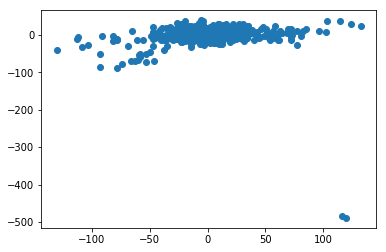

In [26]:
plt.scatter(L[:, 0], L[:, 1])

In [ ]:
#m = U.T @ a
#p = a - (U @ m)
#R_a = np.sqrt(p.T @ p)
#P = (1.0 / R_a) * p
    
#n = V.T @ b
#q = b - (V @ n)
#R_b = np.sqrt(q.T @ q)
#Q = (1. / R_b) * q

In [ ]:
#K = np.array(np.diag(list(np.diag(S)) + [0.0])) + np.bmat('m ; R_a') * np.bmat('n ; R_b').T
#u, s, vt = np.linalg.svd(K, full_matrices = False)

#tUp = np.array(u[:, :k])
#tVp = np.array(vt.T[:, :k])
#tSp = np.diag(s[:k])

In [ ]:
#Up = np.hstack([U, P]) @ tUp
#VpT = tVp.T @ np.hstack([V, Q]).T 
#Up, VpT = svd_flip(Up[:, ::-1], VpT[::-1])
#F_proj = Up @ S
#F_proj = F_proj / np.linalg.norm(F_proj, axis=0, ord=2)

In [ ]:
#l = (F_proj.T @ Z).T
#l.shape

In [ ]:
plt.scatter(L[:, 0], L[:, 1])
plt.scatter(-l[:,0], l[:,1], color = "purple")
plt.scatter(L[i, 0], L[i, 1], color="red")

In [9]:
def svdUpdate(U, S, V, a, b):
    
    S = np.asmatrix(S)
    U = np.asmatrix(U)
    V = np.asmatrix(V)
    a = np.asmatrix(a).reshape(a.size, 1)
    b = np.asmatrix(b).reshape(b.size, 1)
    
    rank = S.shape[0]
    
    # eq (6)
    m = U.T * a
    p = a - U * m
    Ra = np.sqrt(p.T * p)
    P = (1.0 / float(Ra)) * p
    
    # eq (7)
    n = V.T * b
    q = b - V * n
    Rb = np.sqrt(q.T * q)
    Q = (1.0 / float(Rb)) * q
    
    # eq (8)
    K = np.matrix(np.diag(list(np.diag(S)) + [0.0])) + np.bmat('m ; Ra') * np.bmat('n ; Rb').T
    
    # eq (5)
    u, s, vt = np.linalg.svd(K, full_matrices = False)
    tUp = np.matrix(u[:, :rank])
    tVp = np.matrix(vt.T[:, :rank])
    tSp = np.matrix(np.diag(s[: rank]))
    Up = np.bmat('U P') * tUp
    Vp = np.bmat('V Q') * tVp
    Sp = tSp
    
    return Up, Sp, Vp

----

In [ ]:
%%time
cor.jackknife(5, 25)

In [ ]:
plt.scatter(cor.L[:, 0], cor.L[:, 1])
plt.scatter(cor.L_shrunk[:, 0], cor.L_shrunk[:, 1], color="green")

In [ ]:
cor.V.shape

def _svd_rank1(Y, U, S, V, n, p, k, i):
    """
    """
    
    print(n, p)
    a = -Y[:, i].reshape(p, 1)
    b = np.zeros(n).reshape(n, 1)
    b[i] = 1

    m = U.T @ a
    p = a - (U @ m)
    R_a = np.sqrt(p.T @ p)
    P = (1. / R_a) * p

    n = V.T @ b
    q = b - (V @ n)
    R_b = np.sqrt(q.T @ q)
    Q = (1. / R_b) * q
    
    K_0 = np.zeros((S.shape[0] + 1, S.shape[0] + 1))
    K_0[:-1, :-1] = S
    K_1 = np.append(m, R_a).reshape(-1, 1) @ np.append(n, R_b).reshape(1, -1)
    K = K_0 + K_1

    tUp, tSp, tVpT = svds(K, k)
    tUp, tVpT = svd_flip(tUp[:, ::-1], tVpT[::-1])
    tVp = tVpT.T
    
    print(U.shape, P.shape)
    print(a.shape, b.shape)
    print(V.shape, Q.shape, P.shape)

    Up = np.hstack([U, P]) @ tUp
    Sp = np.diag(tSp)
    Vp = np.hstack([V, Q]) @ tVp

    return((Up, Sp, Vp))

_svd_rank1(Z, cor.U, cor.S, cor.V, cor.n, cor.p, cor.k, 1)

cor.V.shape

In [ ]:
def svdUpdate(U, S, V, a, b):
    """
    Update SVD of an (m x n) matrix `X = U * S * V^T` so that
    `[X + a * b^T] = U' * S' * V'^T`
    and return `U'`, `S'`, `V'`.
    
    The original matrix X is not needed at all, so this function implements one-pass
    streaming rank-1 updates to an existing decomposition. 
    
    `a` and `b` are (m, 1) and (n, 1) matrices.
    
    You can set V to None if you're not interested in the right singular
    vectors. In that case, the returned V' will also be None (saves memory).
    
    The blocked merge algorithm in LsiModel.addDocuments() is much faster; I keep this fnc here
    purely for backup reasons.
    This is the rank-1 update as described in
    **Brand, 2006: Fast low-rank modifications of the thin singular value decomposition**,
    but without separating the basis from rotations.
    """
    # convert input to matrices (no copies of data made if already numpy.ndarray or numpy.matrix)
    S = numpy.asmatrix(S)
    U = numpy.asmatrix(U)
    if V is not None:
        V = numpy.asmatrix(V)
    a = numpy.asmatrix(a).reshape(a.size, 1)
    b = numpy.asmatrix(b).reshape(b.size, 1)
    
    rank = S.shape[0]
    
    # eq (6)
    m = U.T * a
    p = a - U * m
    Ra = numpy.sqrt(p.T * p)
    if float(Ra) < 1e-10:
        logger.debug("input already contained in a subspace of U; skipping update")
        return U, S, V
    P = (1.0 / float(Ra)) * p
    
    if V is not None:
        # eq (7)
        n = V.T * b
        q = b - V * n
        Rb = numpy.sqrt(q.T * q)
        if float(Rb) < 1e-10:
            logger.debug("input already contained in a subspace of V; skipping update")
            return U, S, V
        Q = (1.0 / float(Rb)) * q
    else:
        n = numpy.matrix(numpy.zeros((rank, 1)))
        Rb = numpy.matrix([[1.0]])    
    
    if float(Ra) > 1.0 or float(Rb) > 1.0:
        logger.debug("insufficient target rank (Ra=%.3f, Rb=%.3f); this update will result in major loss of information"
                      % (float(Ra), float(Rb)))
    
    # eq (8)
    K = numpy.matrix(numpy.diag(list(numpy.diag(S)) + [0.0])) + numpy.bmat('m ; Ra') * numpy.bmat('n ; Rb').T
    
    # eq (5)
    u, s, vt = numpy.linalg.svd(K, full_matrices = False)
    tUp = numpy.matrix(u[:, :rank])
    tVp = numpy.matrix(vt.T[:, :rank])
    tSp = numpy.matrix(numpy.diag(s[: rank]))
    Up = numpy.bmat('U P') * tUp
    if V is not None:
        Vp = numpy.bmat('V Q') * tVp
    else:
        Vp = None
    Sp = tSp
    
    return Up, Sp, Vp

In [ ]:
"""                                                                                                                                                                                                                                                              m = self.U.T @ a                                                                                                                                                                                                                                         p = a - (self.U @ m)                                                                                                                                                                                                                                     R_a = np.sqrt(p.T @ p)                                                                                                                                                                                                                                   P = (1. / R_a) * p

        n = V.T @ b
        q = b - (V @ n)
        R_b = np.sqrt(q.T @ q)
        Q = (1. / R_b) * q

        K_0 = np.zeros((self.S.shape[0] + 1, self.S.shape[0] + 1))
        K_0[:-1, :-1] = self.S
        K_1 = np.append(m, R_a).reshape(-1, 1) @ np.append(n, R_b).reshape(1, -1)
        K = K_0 + K_1

        C, Sp, DT = svds(K, self.k)
        C, DT = svd_flip(C[:, ::-1], DT[::-1])
        D = DT.T

        U = np.hstack([self.U, P]) @ C
        S = np.diag(Sp)

        return((Up, Sp))
"""